# Projekt IAU 2021, fáza 3 - strojové učenie
Autori: **Matúš Krajčovič**, **Michal Kuklovský**

Podiel práce: obaja 50%

## Zadanie

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania pomocou strojového učenia.
V tejto fáze sa od Vás očakáva:
 
1. **Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu (5b)**

- Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
- Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátor pomocou metrík accuracy, precision a recall.

2. **Natrénovanie a vyhodnotenie klasifikátora strojového učenia (5b)**
- Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.
- Vizualizujte natrénované pravidlá.
- Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
- Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.

3. **Optimalizácia - hyperparameter tuning (5b)**
- Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
- Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

4. **Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)**\
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 

- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov;
- Hyperparameter tuning resp. ensemble learning.

Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.

In [1]:
#pandas and others
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

#pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imputers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold

#custom outlier detection classes classes imports
from sklearn.base import BaseEstimator, TransformerMixin

#encoders
from category_encoders import OrdinalEncoder

#scalers
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler

#transformers
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

#feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2

#feature selection
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

## Načítanie dát
Zmeny vykonané vo fáze 1, vytvorenie trénovacieho a testovacieho datasetu.

In [2]:
labor = pd.read_csv("045/labor.csv", sep='\t', index_col=0)
profiles = pd.read_csv("045/profiles.csv", sep='\t', index_col=0)
labor['smoker'] = labor['smoker'].str.replace('no', 'N')
labor['smoker'] = labor['smoker'].str.replace('yes', 'Y')
labor['relationship'] = labor['relationship'].str.replace('nop', 'single')
labor.rename(columns = {'erytrocyty':'erytrocytes', 'leukocyty':'leukocytes', 'trombocyty': 'trombocytes', 'hematokrit':'hematocrit', 'er-cv': 'ercv'}, inplace = True)
profiles['birthdate'] = pd.to_datetime(profiles.birthdate)
profiles['age'] = (pd.to_datetime(date.today()) - profiles['birthdate'])
profiles['age'] = profiles['age'] / np.timedelta64(1, 'Y')
profiles['race'] = profiles['race'].str.replace('blsck', 'Black')
profiles['race'] = profiles['race'].str.replace('black', 'Black')
profiles['race'] = profiles['race'].str.replace('white', 'White')
profiles = profiles.rename(columns={'blood_group' : 'blood_type'})

labor = labor.drop(columns=['name'])
profiles = profiles.drop(columns=['current_location', 'birthdate', 'name', 'address', 'residence'])

merged = labor.merge(profiles, on='ssn', how='left')
merged = merged.drop(columns='ssn')

## Predspracovanie dát

Pomocné triedy outlier detekcie pre pipelines a pomocné funkcie.

In [3]:
class OutlierReplacer3StdWithPercentiles(BaseEstimator, TransformerMixin):
    def fit(self, target, label=None):
        return self
    def transform(self, target):
        target_ = np.asarray(target)
        std = np.nanstd(target_, axis=0)
        mean = np.nanmean(target_, axis=0)
        cut_off = std * 3
        lower, upper = mean - cut_off, mean + cut_off
        replace_lower = np.quantile(target_, q=0.05, axis=0)
        replace_upper = np.quantile(target_, q=0.95, axis=0)
        for i in range(target_.shape[1]):
            target_[target_[:,i] < lower[i], i] = replace_lower[i]
            target_[target_[:,i] > upper[i], i] = replace_upper[i]
        return target_

class OutlierReplacerIqrWithPercentiles(BaseEstimator, TransformerMixin):
    def fit(self, target, label=None):
        return self
    def transform(self, target):
        target_ = np.asarray(target)
        q25 = np.quantile(target_, q=0.25, axis=0)
        q75 = np.quantile(target_, q=0.75, axis=0)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        replace_lower = np.quantile(target_, q=0.05, axis=0)
        replace_upper = np.quantile(target_, q=0.95, axis=0)
        for i in range(target_.shape[1]):
            target_[target_[:,i] < lower[i], i] = replace_lower[i]
            target_[target_[:,i] > upper[i], i] = replace_upper[i]
        return target_

def transform_to_df(arr, cols, index):
    new_labor = pd.DataFrame(arr)
    new_labor.columns=cols
    new_labor.index=index
    return new_labor

Použijeme kNN imputer, 3xSTD outlier removal, robustné škálovanie, yeo-johnson transformáciu a kódovanie kategorických atribútov a výber atribútov pomocou select from model pre decision tree klasifikátor.

In [4]:
numeric = ['ercv', 'erytrocytes', 'hemoglobin', 'ast', 'leukocytes', 'alp', 'etytr', 'alt', 'hbver', 'hematocrit', 'weight', 'trombocytes', 'age']
categorical = ['smoker', 'relationship', 'sex', 'blood_type', 'race']
indicator = ['indicator']

numeric_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('outlier_remover', OutlierReplacer3StdWithPercentiles()),
    ('scaler', RobustScaler()),
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
])

categorical_pipeline = Pipeline([
    ("encoder", OrdinalEncoder())
])

preprocessing_pipeline = ColumnTransformer([
    ("numeric_preprocessor", numeric_pipeline, numeric),
    ("categorical_preprocessor", categorical_pipeline, categorical)
])

complete_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", SelectFromModel(DecisionTreeClassifier()))
])

Rozdelíme dataset na trénovaciu a testovaciu množinu ktorú transformujeme cez pipelines.

In [5]:
train, test = train_test_split(merged, test_size=0.25)
train = pd.DataFrame(train)
test = pd.DataFrame(test)

train_indicator = train['indicator']
train_df = train.drop(columns=['indicator'])
test_indicator = test['indicator']
test_df = test.drop(columns=['indicator'])

train = complete_pipeline.fit_transform(train_df, train_indicator)
test = complete_pipeline.transform(test_df)

## 1  Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

Trieda OneR ako parametre berie samotné dáta vo forme dataframe-u s indikátorom a stĺpce, ktoré ide kontrolovať.

Metóda **train()** vytvorí všetky pravidlá a uloží najlepšie (pre jeden atribút).

Metóda **predict()** berie dataset ako parameter a vráti sériu predikovaných atribútov pre tento dataset.

Predpokladáme, že hodnoty indikátora sú vždy 0 alebo 1.

In [6]:
class OneR:
    def __init__(self, data, columns):
        self.data = data.copy(deep=True)
        self.columns = columns
        self.rule = None
    def train(self):
        for column in self.columns:
            best = {
                "value": None,
                "left_indicator": None,
                "accuracy": 0,
                "column": None
            }
            tmp = self.data.sort_values(by=column)
            tmp.reset_index(inplace = True)
            for i in range(0, tmp.shape[0]-1):
                left = tmp.loc[0:i].groupby(['indicator']).size().reindex([0.0, 1.0], fill_value=0)
                right = tmp.loc[i+1:tmp.shape[0]-1].groupby(['indicator']).size().reindex([0.0, 1.0], fill_value=0)
                accuracy_1 = (left[0] + right[1])/(self.data.shape[0])
                accuracy_2 = (left[1] + right[0])/(self.data.shape[0])
                if(accuracy_1 >  best['accuracy'] or accuracy_2 > best['accuracy']):
                    best['value'] = tmp.loc[i,column]
                    best['column'] = column
                    if(accuracy_1 > accuracy_2):
                        best['accuracy'] = accuracy_1
                        best['left_indicator'] = 0.0
                    else:
                        best['accuracy'] = accuracy_2
                        best['left_indicator'] = 1.0
            print(best)
            if(not self.rule or self.rule['accuracy'] < best['accuracy']):
                self.rule = best
    def train_results(self):
        print(self.rule)
    def predict(self, data, indicator):
        left = data[(data[self.rule['column']] <= self.rule['value']) & (indicator[data.index] == 1.0)].count()[self.rule['column']]
        right = data[(data[self.rule['column']] > self.rule['value']) & (indicator[data.index] == 0.0)].count()[self.rule['column']]
        print("Accuracy: " + str((left + right)/(data.shape[0])))
        result = pd.DataFrame()
        result.indicator = np.nan
        for index, row in data.iterrows():
            if(row[self.rule['column']] <= self.rule['value']):
                result.loc[index, 'indicator'] = self.rule['left_indicator']
            else:
                result.loc[index, 'indicator'] = (1.0 if self.rule['left_indicator'] == 0.0 else 0.0)
        return result.squeeze()

Naša default pipeline berie tieto 4 stĺpce pre klasifikáciu, my v našom algoritme vyskúšame všetky atribúty.

In [7]:
cols = complete_pipeline.named_steps.estimator.get_support(indices=True)
train_df[numeric].iloc[:,cols].columns

Index(['hemoglobin', 'etytr', 'hbver', 'trombocytes'], dtype='object')

Vytvoríme datasety pre testovanie (z train a test numpy arrays vytvoríme dataframes).

In [8]:
transformed_train = transform_to_df(numeric_pipeline.fit_transform(train_df[numeric], None), numeric, train_df.index)
transformed_train = transformed_train.merge(train_indicator, left_index=True, right_index=True)

transformed_test = transform_to_df(numeric_pipeline.transform(test_df[numeric]), numeric, test_df.index)

Natrénujeme OneR a vypíšeme pravidlá.

In [9]:
oneRmodel = OneR(transformed_train, numeric)
oneRmodel.train()

{'value': 2.9789292875950752, 'left_indicator': 1.0, 'accuracy': 0.6409199680935921, 'column': 'ercv'}
{'value': -3.0394893938698058, 'left_indicator': 0.0, 'accuracy': 0.6409199680935921, 'column': 'erytrocytes'}
{'value': -0.93302691907111, 'left_indicator': 0.0, 'accuracy': 0.653549587875565, 'column': 'hemoglobin'}
{'value': 2.6881356932764953, 'left_indicator': 1.0, 'accuracy': 0.6418505716564743, 'column': 'ast'}
{'value': 3.030557102876789, 'left_indicator': 1.0, 'accuracy': 0.6410529114597182, 'column': 'leukocytes'}
{'value': -1.6840088135478244, 'left_indicator': 0.0, 'accuracy': 0.6417176282903483, 'column': 'alp'}
{'value': -2.7876166260649122, 'left_indicator': 0.0, 'accuracy': 0.6417176282903483, 'column': 'etytr'}
{'value': -3.7403124458161474, 'left_indicator': 0.0, 'accuracy': 0.6410529114597182, 'column': 'alt'}
{'value': 0.9012892590926468, 'left_indicator': 1.0, 'accuracy': 0.6539484179739431, 'column': 'hbver'}
{'value': -2.7023189189182037, 'left_indicator': 0.0, 

Vypíšeme najlepšie pravidlo.

In [10]:
oneRmodel.train_results()

{'value': 0.8554918812478984, 'left_indicator': 1.0, 'accuracy': 0.7309226269609147, 'column': 'trombocytes'}


Predikujeme na testovacej množine a vypíšeme úspešnosť.

In [11]:
result_indicator = oneRmodel.predict(transform_to_df(transformed_test, numeric, test_df.index), test_indicator)

Accuracy: 0.7515948963317385


Vypíšeme presnosť (precision, recall, f1) a maticu.

              precision    recall  f1-score   support

         0.0       0.75      0.46      0.57       891
         1.0       0.75      0.91      0.83      1617

    accuracy                           0.75      2508
   macro avg       0.75      0.69      0.70      2508
weighted avg       0.75      0.75      0.73      2508


confusion matrix:


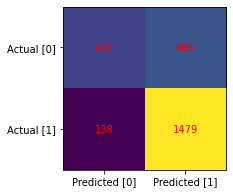

In [12]:
print(classification_report(test_indicator, result_indicator))
print("\nconfusion matrix:")
cm = confusion_matrix(test_indicator, result_indicator)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted [0]', 'Predicted [1]'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual [0]', 'Actual [1]'))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

## 2  Natrénovanie a vyhodnotenie klasifikátora strojového učenia

Funkcia ktorá analyzuje presnosť daného stromoveho klasifikačného algoritmu.

In [13]:
def analyze_tree(model, train_x, test_x, train_y, test_y, verbose):
    model = model.fit(train_x, train_y)
    
    train_predict = model.predict(train_x)
    test_predict = model.predict(test_x)

    print("accuracy:")
    print(" train: " + str(accuracy_score(train_y, train_predict)))
    print(" test: " + str(accuracy_score(test_y, test_predict)))
    
    print("\ncross validation score:")
    print(" " + str(cross_val_score(model, train_x, train_y, cv=10)))
    
    if(verbose):
        
        print("\ntest sample report:")
        print(classification_report(test_y, test_predict))
        
        print("\nconfusion matrix:")
        cm = confusion_matrix(test_y, test_predict)
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(cm)
        ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted [0]', 'Predicted [1]'))
        ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual [0]', 'Actual [1]'))
        for i in range(2):
            for j in range(2):
                ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        
        if(isinstance(model, DecisionTreeClassifier)):
            fig, ax = plt.subplots(figsize=(15, 10))
            plot_tree(model, ax=ax, max_depth=2)
            plt.show()
            fig2, ax2 = plt.subplots(figsize=(15, 10))
            plot_tree(model, ax=ax2)
            plt.show()

Analyzujeme rozhodovací strom na predspracovaných dátach.

accuracy:
 train: 1.0
 test: 0.879585326953748

cross validation score:
 [0.86719788 0.88047809 0.87632979 0.89494681 0.86037234 0.8856383
 0.87632979 0.87367021 0.87632979 0.8856383 ]

test sample report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       891
         1.0       0.91      0.91      0.91      1617

    accuracy                           0.88      2508
   macro avg       0.87      0.87      0.87      2508
weighted avg       0.88      0.88      0.88      2508


confusion matrix:


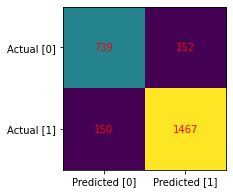

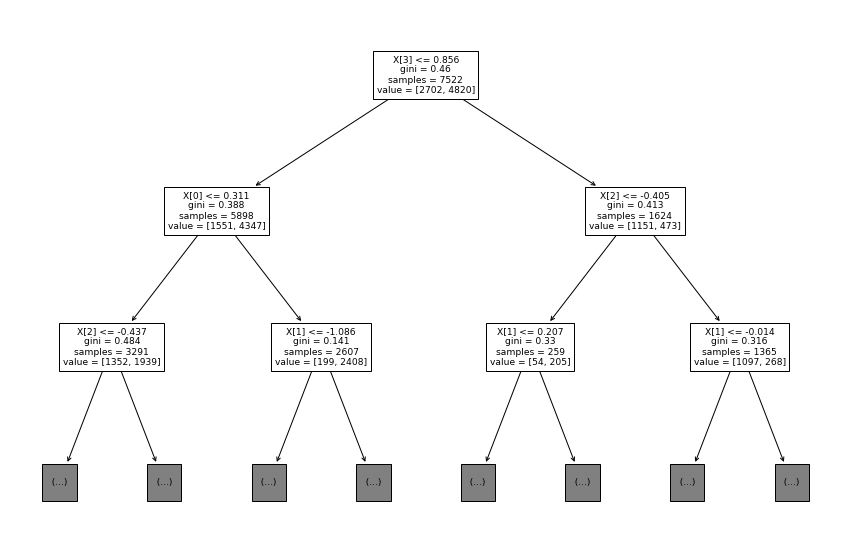

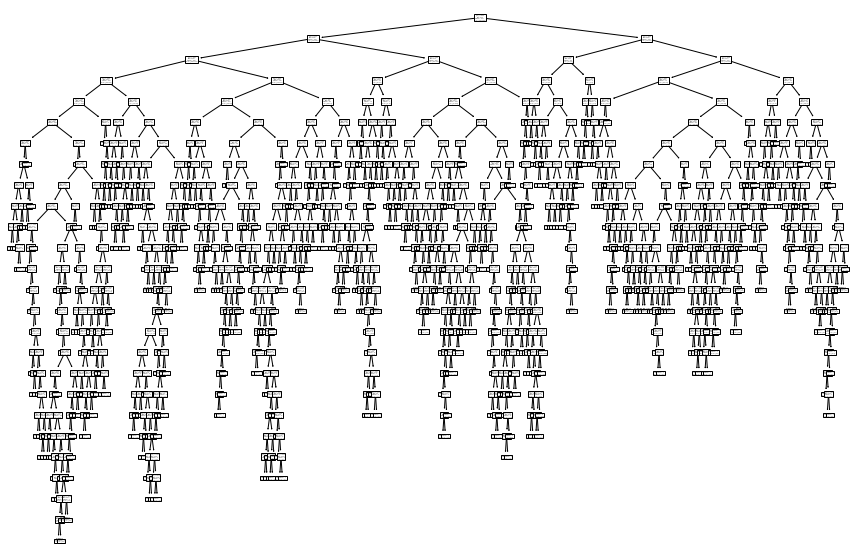

In [14]:
analyze_tree(DecisionTreeClassifier(), train, test, train_indicator, test_indicator, verbose=True)

Vyskúšame tiež náhodný les.

accuracy:
 train: 1.0
 test: 0.9234449760765551

cross validation score:
 [0.90703851 0.92031873 0.94281915 0.93617021 0.92420213 0.93085106
 0.93351064 0.92021277 0.92154255 0.92952128]

test sample report:
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       891
         1.0       0.93      0.95      0.94      1617

    accuracy                           0.92      2508
   macro avg       0.92      0.91      0.92      2508
weighted avg       0.92      0.92      0.92      2508


confusion matrix:


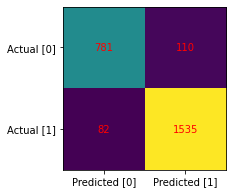

In [15]:
analyze_tree(RandomForestClassifier(), train, test, train_indicator, test_indicator, verbose=True)

### Porovnanie

Naša implementácia OneR rozhodovacieho stromu dosahuje úspešnosť 75%. Rozhoduje sa podľa atribútu 'trombocytes' pri hraničnej hodnote 0.86 (hodnoty už sú zoškálované a transformované cez pipeline).

V porovnaní z algoritmami z knižnice sklearn bola úspešnosť našej implementácie nižšia. Pri týchto dosahovala až 87% pri rozhodovacom strome a 93% pri náhodnom lese.

## 3  Optimalizácia - hyperparameter tuning

Parametre, ktoré pri rozhodovacom strome testujeme sú:
- **criterion** = meranie kvality rozdeľovania datasetu pri uzloch (gini, entropy)
- **splitter** = ako sa rozdeľuje dataset v uzloch (best, random)
- **max_depth** = aký hlboký môže byť strom
- **min_samples_split** = minimálny počet prvkov v uzle na to, aby sa mohol ďalej deliť
- **min_samples_leaf** = minimálny počet prvkov v uzle na to, aby sa mohol stať listom
- **min_weight_fraction_leaf** = každá vzorka musí mať minimálny podiel z celkovej sumy váh v uzle
- **max_leaf_nodes** = koľko maximálne môžeme mať listov
- **min_impurity_decrease** = uzol sa rozdelí iba keď impurity bude vyššia ako táto hodnota
- **class_weight** = každému atribútu vieme priradiť jeho váhu, voľba balanced sama nastaví váhy
- **ccp_alpha** = orezávanie stromu

Pri náhodnom lese okrem vyššie spomenutých skúmame aj:
- **bootstrap** = pri stromoch sa používa bootstrap výber
- **oob_score** = berieme do úvahy aj prvky mimo bootstrap výberov

Netestujeme:
- max_features = koľko maximálne atribútov skúmame (máme iba 4 ktoré vypadli z SelectFromModel algoritmu)
- random_state = stav náhodnosti, nechávame na 1 aby sme mohli provnávať ostatné parametre

Jednotlivé kombinácie parametrov, ktoré budeme testovať:

In [16]:
params_arr = [
    {
        "name" : "default (gini)", 
        "params" : {
            'criterion': 'gini',
            'random_state' : 1
        }
    },
    {
        "name" : "entropy", 
        "params" : {
            'criterion': 'entropy',
            'random_state' : 1
        }
    },
    {
        "name" : "max-depth 5", 
        "params" : { 
            'max_depth': 5,
            'random_state' : 1
        }
    },
    {
        "name" : "max-depth 10", 
        "params" : { 
            'max_depth': 10,
            'random_state' : 1
        }
    },
    {
        "name" : "max-depth 15", 
        "params" : { 
            'max_depth': 15,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_split 3", 
        "params" : { 
            'min_samples_split': 3,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_split 4", 
        "params" : { 
            'min_samples_split': 4,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_leaf 2", 
        "params" : { 
            'min_samples_leaf': 2,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_leaf 5", 
        "params" : { 
            'min_samples_leaf': 5,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_leaf 10", 
        "params" : { 
            'min_samples_leaf': 10,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_leaf 20", 
        "params" : { 
            'min_samples_leaf': 20,
            'random_state' : 1
        }
    },
    {
        "name" : "min_samples_leaf 30", 
        "params" : { 
            'min_samples_leaf': 30,
            'random_state' : 1
        }
    },
    {
        "name" : "min_weight_fraction_leaf 0.01", 
        "params" : { 
            'min_weight_fraction_leaf': 0.01,
            'random_state' : 1
        }
    },
    {
        "name" : "class_weight balanced", 
        "params" : { 
            'class_weight': 'balanced',
            'random_state' : 1
        }
    },
    {
        "name" : "max_leaf_nodes 2", 
        "params" : { 
            'max_leaf_nodes': 2,
            'random_state' : 1
        }
    },
    {
        "name" : "max_leaf_nodes 10", 
        "params" : { 
            'max_leaf_nodes': 10,
            'random_state' : 1
        }
    },
    {
        "name" : "min_impurity_decrease 0.1", 
        "params" : { 
            'min_impurity_decrease': 0.1,
            'random_state' : 1
        }
    },
    {
        "name" : "min_impurity_decrease 0.001", 
        "params" : { 
            'min_impurity_decrease': 0.001,
            'random_state' : 1
        }
    },
    {
        "name" : "min_impurity_decrease 0.0001", 
        "params" : { 
            'min_impurity_decrease': 0.0001,
            'random_state' : 1
        }
    },
    {
        "name" : "ccp_alpha 0.001", 
        "params" : { 
            'ccp_alpha': 0.001,
            'random_state' : 1
        }
    },
    {
        "name" : "ccp_alpha 0.0001", 
        "params" : { 
            'ccp_alpha': 0.0001,
            'random_state' : 1
        }
    },
    {
        "name" : "combination", 
        "params" : {
            'min_samples_leaf': 15,
            'min_samples_split': 3,
            'max_depth': 15,
            'ccp_alpha': 0.0001,
            'random_state' : 1
        }
    },
    {
        "name" : "combination", 
        "params" : {
            'min_samples_leaf': 20,
            'min_samples_split': 3,
            'max_depth': 20,
            'ccp_alpha': 0.0001,
            'random_state' : 1
        }
    }
]

params_arr_tree = [
    {
        "name" : "random splitter", 
        "params" : {
            'splitter': 'random',
            'random_state' : 1
        }
    }
]

params_arr_forest = [
    {
        "name" : "bootstrap", 
        "params" : {
            'bootstrap': True,
            'random_state' : 1
        }
    },
    {
        "name" : "bootstrap oob_score", 
        "params" : {
            'bootstrap': True,
            'oob_score': True,
            'random_state' : 1
        }
    }
]

Všetky kombinácie parametrov vyskúšame na rozhodovacích stromoch, z ktorých každý analyzujeme aj cross validáciou.

In [17]:
for item in params_arr + params_arr_tree:
    print("NAME: " + item['name'] + '\n')
    analyze_tree(DecisionTreeClassifier(**(item['params'])), train, test, train_indicator, test_indicator, False)
    print('----------------------------------\n')

NAME: default (gini)

accuracy:
 train: 1.0
 test: 0.8775917065390749

cross validation score:
 [0.87383798 0.88977424 0.88031915 0.89095745 0.86037234 0.88962766
 0.87367021 0.87632979 0.87765957 0.88696809]
----------------------------------

NAME: entropy

accuracy:
 train: 1.0
 test: 0.8740031897926634

cross validation score:
 [0.85126162 0.875166   0.87898936 0.88829787 0.87898936 0.89893617
 0.88164894 0.86835106 0.88164894 0.88430851]
----------------------------------

NAME: max-depth 5

accuracy:
 train: 0.8931135336346716
 test: 0.8859649122807017

cross validation score:
 [0.87649402 0.87250996 0.90159574 0.87632979 0.86968085 0.89228723
 0.88031915 0.88962766 0.86835106 0.88297872]
----------------------------------

NAME: max-depth 10

accuracy:
 train: 0.9566604626429142
 test: 0.8963317384370016

cross validation score:
 [0.88180611 0.89243028 0.89228723 0.91090426 0.87765957 0.9162234
 0.91356383 0.88962766 0.90026596 0.90425532]
----------------------------------

NAM

Vyskúšame to aj pri náhodnom lese.

In [18]:
for item in params_arr + params_arr_forest:
    print("NAME: " + item['name'] + '\n')
    analyze_tree(RandomForestClassifier(**(item['params'])), train, test, train_indicator, test_indicator, False)
    print('----------------------------------\n')

NAME: default (gini)

accuracy:
 train: 1.0
 test: 0.9250398724082934

cross validation score:
 [0.91766268 0.92031873 0.94414894 0.93351064 0.9268617  0.93085106
 0.93085106 0.91489362 0.92287234 0.92952128]
----------------------------------

NAME: entropy

accuracy:
 train: 1.0
 test: 0.9238437001594896

cross validation score:
 [0.91633466 0.9189907  0.94680851 0.93351064 0.92154255 0.93218085
 0.93351064 0.92021277 0.91888298 0.93218085]
----------------------------------

NAME: max-depth 5

accuracy:
 train: 0.8975006647168307
 test: 0.8863636363636364

cross validation score:
 [0.88446215 0.88313413 0.90558511 0.89361702 0.87765957 0.89228723
 0.8962766  0.87765957 0.88164894 0.88031915]
----------------------------------

NAME: max-depth 10

accuracy:
 train: 0.960515820260569
 test: 0.919457735247209

cross validation score:
 [0.92164675 0.9123506  0.94281915 0.9268617  0.91888298 0.92819149
 0.93085106 0.9162234  0.91489362 0.92952128]
----------------------------------

NAME

### Závery

Pri testovaní parametra pre algoritmus DecisionTreeClassifier:
- **criterion:** minimálne rozdiely, entropy vyšlo tesne lepšie
- **max_depth:** znižovaním parametra max_depth sme znižovali pretrénovanie, najlepšie výsledky sme dosiahli pre hodnotu parametra 10
- **min_samples_split:** minimálne rozdiely, lepší výsledok pre hodnotu 4
- **min_samples_leaf:** zvyšovaním počtu listov sme znižovali pretrénovanie a zvyšovali úspešnosť, najlepšie výsledky sme dosiahli pre hodnotu 20
- **min_weight_fraction_leaf:** úspešnosť sa pri hodnote 0,01 zvýšila
- **max_leaf_nodes:** pri vyššom počte listov došlo k lepšiemu natrénovaniu modelu a presnejším pridikciám na testovacej množine
- **min_impurity_decrease:** vďaka častejšiemu deleniu uzlov sa zvýšila úspešnosť modelu
- **class_weight:** táto možnosť znížila úspešnosť predikcie
- **ccp_alpha:** pre 0.001 je nižšie pretrénovanie a vyššia úspešnosť ako pri hodnote 0.0001
- **random_splitter:** táto možnosť znížila úspešnosť predikcie

Skúšali sme tiež rôzne kombinácie viacerých parametrov, pri ktorých sme dosiahli úspešnosť okolo 90%.

## 4  Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

Vytvoríme si testovacie pipelines aby sme mohli skúšať rôzne kombinácie predspracovania.

In [19]:
pipelines = [
    {
        "name": "default",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('outlier_remover', OutlierReplacer3StdWithPercentiles()),
                    ('scaler', RobustScaler()),
                    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "only kNN imputer",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer())
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "only median imputer",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', SimpleImputer(strategy='median'))
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with 3xSTD replacer",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('outlier_remover', OutlierReplacer3StdWithPercentiles())
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with Iqr replacer",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('outlier_remover', OutlierReplacerIqrWithPercentiles())
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with robust scaler",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('scaler', RobustScaler())
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with standard scaler",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('scaler', StandardScaler())
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with MinMax scaler",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('scaler', MinMaxScaler())
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with yeo-johnson power transformer",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True))
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with quantile transformer",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                    ('transformer', QuantileTransformer(n_quantiles=10, output_distribution='normal'))
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(DecisionTreeClassifier(random_state=1)))
        ])
    },
    {
        "name": "kNN imputer with selectKbest (f regression, k=10)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectKBest(f_regression, k=10))
        ])
    },
    {
        "name": "kNN imputer with selectKbest (f regression, k=5)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectKBest(f_regression, k=5))
        ])
    },
    {
        "name": "kNN imputer with selectKbest (f regression, k=3)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectKBest(f_regression, k=3))
        ])
    },
    {
        "name": "kNN imputer with selectKbest (mutual information, k=10)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectKBest(mutual_info_regression, k=10))
        ])
    },
    {
        "name": "kNN imputer with selectKbest (mutual information, k=5)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectKBest(mutual_info_regression, k=5))
        ])
    },
    {
        "name": "kNN imputer with selectKbest (mutual information, k=3)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectKBest(mutual_info_regression, k=3))
        ])
    },
    {
        "name": "kNN imputer with selectFromModel (logistic regression, k=10)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", RFE(LogisticRegression(solver='lbfgs', max_iter=1000), n_features_to_select=10, step=1))
        ])
    },
    {
        "name": "kNN imputer with selectFromModel (logistic regression, k=5)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", RFE(LogisticRegression(solver='lbfgs', max_iter=1000), n_features_to_select=5, step=1))
        ])
    },
    {
        "name": "kNN imputer with selectFromModel (logistic regression, k=3)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", RFE(LogisticRegression(solver='lbfgs', max_iter=1000), n_features_to_select=3, step=1))
        ])
    },
    {
        "name": "kNN imputer with selectFromModel (SVC)",
        "pipeline" : Pipeline([
            ("preprocessor", ColumnTransformer([
                ("numeric_preprocessor", Pipeline([
                    ('imputer', KNNImputer()),
                ]), numeric),
                ("categorical_preprocessor", Pipeline([
                    ("encoder", OrdinalEncoder())
                ]), categorical)
            ])),
            ("estimator", SelectFromModel(estimator=LinearSVC(C=0.01, penalty="l1", dual=False)))
        ])
    }
]

Všetky kombinácie otestujeme na modeli rozhodovacieho stromu.

In [20]:
for pipe in pipelines:
    train = pipe['pipeline'].fit_transform(train_df, train_indicator)
    test = pipe['pipeline'].transform(test_df)
    print("NAME: " + pipe['name'] + '\n')
    analyze_tree(DecisionTreeClassifier(random_state=1), train, test, train_indicator, test_indicator, verbose=False)
    print('----------------------------------\n')

NAME: default

accuracy:
 train: 1.0
 test: 0.8775917065390749

cross validation score:
 [0.87383798 0.88977424 0.88031915 0.89095745 0.86037234 0.88962766
 0.87367021 0.87632979 0.87765957 0.88696809]
----------------------------------

NAME: only kNN imputer

accuracy:
 train: 1.0
 test: 0.8775917065390749

cross validation score:
 [0.87782205 0.88446215 0.88297872 0.88297872 0.86835106 0.89228723
 0.86968085 0.88430851 0.87101064 0.88696809]
----------------------------------

NAME: only median imputer

accuracy:
 train: 1.0
 test: 0.8763955342902712

cross validation score:
 [0.88446215 0.88844622 0.8856383  0.89095745 0.86170213 0.88430851
 0.86702128 0.85904255 0.87101064 0.88297872]
----------------------------------

NAME: kNN imputer with 3xSTD replacer

accuracy:
 train: 1.0
 test: 0.8775917065390749

cross validation score:
 [0.87383798 0.88977424 0.88031915 0.89095745 0.86037234 0.88962766
 0.87367021 0.87632979 0.87765957 0.88696809]
----------------------------------

NAM

### Závery
Pri pôvodnej stratégii z fázy 2 sme dospeli k úpešnosti 87,68%. Použili sme pri nej:
- KNNImputer
- Nahradenie trojnásobkom štandardnej odchýlky 
- RobustScaler
- PowerTransformer
- OrdinalEncoder
- SelectFromModel
  - DecisionTreeClassifier

#### Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu
- **imputer:** testovali sme KNNImputer a SimpleImputer pre stratégiu mediánu a najlepšiu úspešnosť mal KNNImputer(), ten preto používame aj pri ostatných stratégiách
- **outlier_remover:** testovali sme nahradenie 3xSTD a IQR, najlepšiu úspešnosť malo nahradenie IQR, no rozdiely boli minimálne
- **scaler:** pri použití rôznych scalerov (Standard, MinMax, Robust) sme nedosiahli zlepšenie úspešnosti
- **transformer:** pri použití rôznych transformerov (yeo-johnson power, quantile)  sme nedosiahli zlepšenie úspešnosti
- **estimator:**
  - **SelectKBest (f regression):** najlepšiu úspešnosť sme dosiahli pri počte čŕt 10
  - **SelectKBest (mutual information):** najlepšiu úspešnosť sme dosiahli pri počte čŕt 5
  - **SelectFromModel (logistic regression):** najlepšiu úspešnosť sme dosiahli pri počte čŕt 5
  - **SelectFromModel (SVC):** dosiahol najnižšiu úspešnosť <br>
    Najvyššiu úspešnosť dosiahli algoritmy SelectFromModel pre logistic regresson a decesion tree classifier.

